
# Information about the data
Source: https://figshare.com/articles/dataset/SDWPF_dataset/24798654 and https://www.nature.com/articles/s41597-024-03427-5 

The sdwpf_full dataset offers more information than what was released for the KDD Cup 2022. It includes not only SCADA data but also weather data such as relative humidity, wind speed, and wind direction, sourced from the Fifth Generation of the European Centre for Medium-Range Weather Forecasts (ECMWF) atmospheric reanalyses of the global climate (ERA5). The dataset encompasses data collected over two years from a wind farm with 134 wind turbines, covering the period from January 2020 to December 2021 The folder structure of sdwpf_full is:

sdwpf_kddcup

The sdwpf_kddcup dataset is the original dataset used for Baidu KDD Cup 2022 Challenge. [...]

The descriptions of each sub-folder in the sdwpf_kddcup dataset are as follows:

- sdwpf_245days_v1.csv: This dataset, released for the KDD Cup 2022 challenge, includes data spanning 245 days.
- sdwpf_baidukddcup2022_turb_location.csv: This file provides the relative positions of all wind turbines within the dataset.
- final_phase_test: This dataset serves as the test data for the final phase of the Baidu KDD Cup. It allows for a comparison of methodologies against those of the award-winning teams from KDD Cup 2022. It includes an 'infile' folder containing input data for the model, and an 'outfile' folder which holds the ground truth for the corresponding output. In other words, for a model function y = f(x), x represents the files in the 'infile' folder, and the ground truth of y corresponds to files in the 'outfile' folder, such as {001out} = f({001in}).

## Columns
- TurbID: The unique identifier for each wind turbine.
- Day: Day of the data point.
- Tmstamp: The timestamp of the data point.
- Wspd: Wind speed (m/s).
- Wdir: The angle between the wind direction and the position of turbine nacelle (degrees).
- Etmp: Temperature of the surounding environment (°C).
- Itmp: Temperature inside the turbine nacelle (°C).
- Ndir: Nacelle direction, i.e., the yaw angle of the nacelle (degrees).
- Pab1: Blade angle 1 (degrees).
- Pab2: Blade angle 2 (degrees).
- Pab3: Blade angle 3 (degrees).
- Prtv: Reactive power (kW).
- Patv: Active power (kW) --> Target variable.

## Unknown Values
We introduce two conditions to determine whether the target variable is unknown:

- When Patv≤0, and Wspd > 2.5 at time t, the actual active power Patv of this wind turbine at time t is unknown (since the wind speed is large enough to generate the power, the only reason that Patv≤0 is this turbine is stopped);
- When Pab1 > 89° or Pab2 > 89° or Pab3 > 89° (Pab1, Pab2, and Pab3 always have the same values) at time t, the actual active power Patv of this wind turbine at time t should be unknown (since no matter at then how large the wind speed is, the wind turbine is at rest in this situation).


In [3]:
import pandas as pd
df = pd.read_parquet('../../data/sdwpf_full/sdwpf_2001_2112_full.parquet')  # assuming the 'data' folder is in the root dir of the project

# sort df by TurbID and Tmstamp
df = df.sort_values(by=['TurbID', 'Tmstamp'])

# reindex df
df = df.reset_index(drop=True)

df.head()

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
0,57,2020-01-03 04:25:00,7.935,0.055,2.185,23.415,236.59,-0.840,-0.840,-0.845,29.680,-12.312683,85893.515625,0.529154,5.191925,52.389540,0.0,976.925
1,57,2020-01-03 04:55:00,6.425,-1.860,2.945,23.550,236.59,-0.610,-0.605,-0.610,14.480,-12.312683,85893.515625,0.529154,5.191925,52.389540,0.0,610.830
2,57,2020-01-03 05:25:00,5.945,-1.635,3.720,23.350,236.59,-0.435,-0.435,-0.435,15.270,-11.709015,85836.429688,0.516070,5.563238,56.420248,0.0,483.850
3,57,2020-01-03 05:55:00,6.290,1.220,4.385,23.285,236.59,-0.510,-0.510,-0.510,19.030,-11.709015,85836.429688,0.516070,5.563238,56.420248,0.0,536.970
4,57,2020-01-03 06:25:00,5.650,3.790,4.945,23.265,243.84,-0.355,-0.355,-0.355,9.795,-10.475830,85820.765625,0.515158,6.000677,55.780818,0.0,431.700


Observations: 
- When [Wspd	Wdir	Etmp	Itmp	Ndir	Pab1	Pab2	Pab3	Prtv] are nan, 'Patv' is also nan: 
- [Wspd	Wdir	Etmp	Itmp	Ndir	Pab1	Pab2	Pab3	Prtv] are periodically nan 

## Negative Values
- When a wind turbine is not producing power, the control system and sensors still draw power leading to negative values.


In [ ]:
# count how many negative values there are

# convert to int
(df['Patv'] < 0).astype(int).sum()  # 1.2 million rows out of 4.7 million are negative --> roughly 25%

# which turbines have the most negative values?
# filter for negative values
df_negative = df[df['Patv'] < 0]
# count how many negative values there are for each turbine
df_negative['TurbID'].value_counts()

## Check for unknown values

In [36]:
# When Patv≤0, and Wspd > 2.5 at time t, the actual active power Patv of this wind turbine at time t is unknown
df[(df['Patv'] <= 0) & (df['Wspd'] > 2.5)][['TurbID', 'Wspd', 'Patv']].describe()

,TurbID,Wspd,Patv
count,514459.000000,514459.000000,514459.000000
mean,69.761886,6.702039,-0.278787
std,39.061179,4.624019,0.210270
min,1.000000,2.505000,-8.440000
25%,35.000000,2.760000,-0.300000
50%,72.000000,4.480000,-0.300000
75%,104.000000,10.380000,-0.300000
max,134.000000,56.870000,0.000000


- we have 514.459 samples where the turbine is stopped and the Patv value is unknown
- we should not consiver these samples for training the model

Text(0.5, 1.0, 'Distribution of Unknown Patv Values')

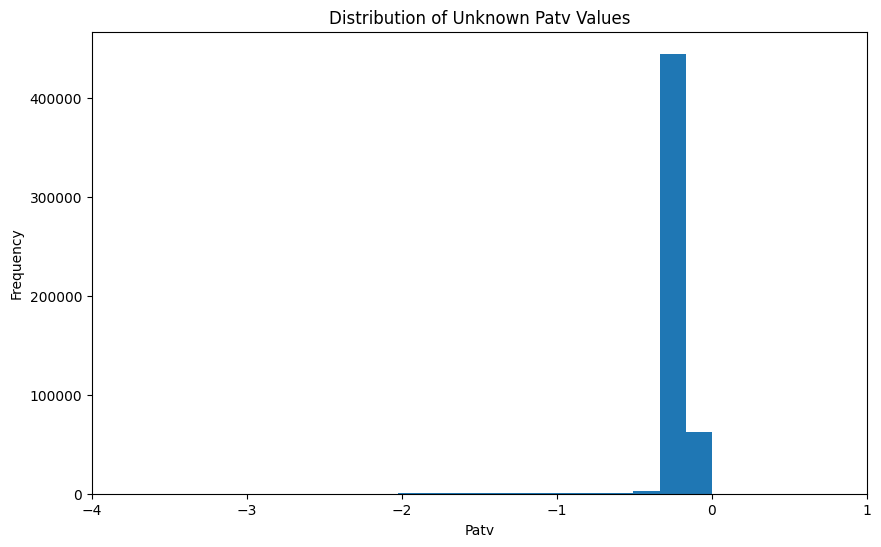

In [34]:
import matplotlib.pyplot as plt
# plot the distribution of Patv for the turbines that have unknown values
plt.figure(figsize=(10, 6))
df[(df['Patv'] <= 0) & (df['Wspd'] > 2.5)]['Patv'].plot(kind='hist', bins=50)
plt.xlim(-4, 1)  # restrict x-axis from -4 to 1
plt.xlabel('Patv')
plt.ylabel('Frequency')
plt.title('Distribution of Unknown Patv Values')


In [ ]:
pd.set_option('display.max_rows', 1000) 
df[:1000]

In [ ]:
pd.set_option('display.max_rows', 1000) 

df_57 = df[df['TurbID'] == 57]

# sort by timestamp
df_57.sort_values(by='Tmstamp')[:100]



In [9]:
# check data types and missing values
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11361190 entries, 0 to 11361189
Data columns (total 18 columns):
 #   Column   Non-Null Count     Dtype         
---  ------   --------------     -----         
 0   TurbID   11361190 non-null  int64         
 1   Tmstamp  11361190 non-null  datetime64[ns]
 2   Wspd     10864192 non-null  float64       
 3   Wdir     10864192 non-null  float64       
 4   Etmp     10864192 non-null  float64       
 5   Itmp     10864192 non-null  float64       
 6   Ndir     10864192 non-null  float64       
 7   Pab1     10864192 non-null  float64       
 8   Pab2     10864192 non-null  float64       
 9   Pab3     10864192 non-null  float64       
 10  Prtv     10864192 non-null  float64       
 11  T2m      11356902 non-null  float32       
 12  Sp       11356902 non-null  float32       
 13  RelH     11356902 non-null  float32       
 14  Wspd_w   11356902 non-null  float64       
 15  Wdir_w   11356902 non-null  float64       
 16  Tp       1135690

In [8]:
# shwo rows that contain missing values
df[df.isnull().any(axis=1)]

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,T2m,Sp,RelH,Wspd_w,Wdir_w,Tp,Patv
1924344,57,2020-01-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924345,57,2020-01-01 00:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924346,57,2020-01-01 01:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924347,57,2020-01-01 01:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924348,57,2020-01-01 02:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11360756,123,2021-12-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.241211,86390.398438,0.608812,3.552270,37.483374,0.0,NaN
11360773,123,2021-12-29 02:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.604462,86324.031250,0.611791,3.867716,35.596275,0.0,NaN
11360854,123,2021-12-29 16:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.847260,86413.257812,0.320186,4.753279,257.942972,0.0,NaN
11361188,123,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.099030,86257.429688,0.613977,3.329529,24.708881,0.0,NaN


## Check the 245days dataset



Does it contain so many null values as well? Appearently not -> maybe limit my analysis to the same time period as the 245days dataset but on the ful ldataset to get the weather data as well?
- which time period is the 245days dataset? 

In [5]:
df_245 = pd.read_csv('../../data/sdwpf_kddcup/sdwpf_245days_v1.csv')
df_245.head()


,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [6]:
# check data types and missing values
df_245.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   TurbID   4727520 non-null  int64  
 1   Day      4727520 non-null  int64  
 2   Tmstamp  4727520 non-null  object 
 3   Wspd     4678002 non-null  float64
 4   Wdir     4678002 non-null  float64
 5   Etmp     4678002 non-null  float64
 6   Itmp     4678002 non-null  float64
 7   Ndir     4678002 non-null  float64
 8   Pab1     4678002 non-null  float64
 9   Pab2     4678002 non-null  float64
 10  Pab3     4678002 non-null  float64
 11  Prtv     4678002 non-null  float64
 12  Patv     4678002 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


# Conclusion

I will focus on the original dataset (sdwpf_kddcup) to make my models more comparable to the original challenge. Also, the data quality seems to be better than the full dataset (less missing values).

## Find out date range of the 245days dataset

In [13]:
import pandas as pd
df = pd.read_parquet('../../data/sdwpf_full/sdwpf_2001_2112_full.parquet')  # assuming the 'data' folder is in the root dir of the project
# sort df by TurbID and Tmstamp
df = df.sort_values(by=['TurbID', 'Tmstamp'])
# reindex df
df = df.reset_index(drop=True)

# only keep columns TurbID, Tmstamp, Wspd, Wdir, Etmp, Itmp, Patv, Pab1, Pab2, Pab3, Prtv
df = df[['TurbID', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Patv', 'Pab1', 'Pab2', 'Pab3', 'Prtv']]
df[df['Wspd'].notna()]


,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Patv,Pab1,Pab2,Pab3,Prtv
193,1,2020-01-03 00:25:00,10.440,-0.450,2.050,19.81,1503.050,1.010,1.010,1.010,9.10
194,1,2020-01-03 00:40:00,10.440,-0.450,2.050,19.81,1503.050,1.010,1.010,1.010,9.10
195,1,2020-01-03 00:55:00,9.755,-1.930,1.890,19.71,1336.245,1.005,1.005,1.005,2.92
196,1,2020-01-03 01:10:00,9.070,-3.410,1.730,19.61,1169.440,1.000,1.000,1.000,-3.26
197,1,2020-01-03 01:25:00,9.730,0.975,1.895,19.48,1328.700,1.000,1.000,1.000,-3.06
...,...,...,...,...,...,...,...,...,...,...,...
11361183,134,2021-12-31 23:10:00,0.930,37.710,5.040,15.80,-0.300,90.370,90.380,90.120,-0.30
11361184,134,2021-12-31 23:20:00,1.210,43.940,4.580,15.07,-0.300,90.370,90.380,90.120,-0.30
11361185,134,2021-12-31 23:30:00,1.320,51.840,4.180,14.38,-0.300,90.370,90.380,90.120,-0.30
11361186,134,2021-12-31 23:40:00,2.150,52.980,4.100,13.78,-0.300,90.370,90.380,90.120,-0.30


In [17]:
# round numeric columns to 2 decimal places
df = df.round(2)
df[df['Wspd'].notna()]

,TurbID,Tmstamp,Wspd,Wdir,Etmp,Itmp,Patv,Pab1,Pab2,Pab3,Prtv
193,1,2020-01-03 00:25:00,10.44,-0.45,2.05,19.81,1503.05,1.01,1.01,1.01,9.10
194,1,2020-01-03 00:40:00,10.44,-0.45,2.05,19.81,1503.05,1.01,1.01,1.01,9.10
195,1,2020-01-03 00:55:00,9.76,-1.93,1.89,19.71,1336.24,1.00,1.00,1.00,2.92
196,1,2020-01-03 01:10:00,9.07,-3.41,1.73,19.61,1169.44,1.00,1.00,1.00,-3.26
197,1,2020-01-03 01:25:00,9.73,0.98,1.90,19.48,1328.70,1.00,1.00,1.00,-3.06
...,...,...,...,...,...,...,...,...,...,...,...
11361183,134,2021-12-31 23:10:00,0.93,37.71,5.04,15.80,-0.30,90.37,90.38,90.12,-0.30
11361184,134,2021-12-31 23:20:00,1.21,43.94,4.58,15.07,-0.30,90.37,90.38,90.12,-0.30
11361185,134,2021-12-31 23:30:00,1.32,51.84,4.18,14.38,-0.30,90.37,90.38,90.12,-0.30
11361186,134,2021-12-31 23:40:00,2.15,52.98,4.10,13.78,-0.30,90.37,90.38,90.12,-0.30


In [18]:
df_245 = pd.read_csv('../../data/sdwpf_kddcup/sdwpf_245days_v1.csv')
# sort df by TurbID and Tmstamp
df_245 = df_245.sort_values(by=['TurbID', 'Tmstamp'])
# reindex df
df_245 = df_245.reset_index(drop=True)

# round numeric columns to 2 decimal places
df_245 = df_245.round(2)

df_245.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [15]:
df_245.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,00:00,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
2,1,3,00:00,11.45,-2.16,26.84,40.28,7.42,1.05,1.05,1.05,-0.18,1549.45
3,1,4,00:00,10.35,-0.14,24.75,39.12,40.95,1.01,1.01,1.01,-0.27,1487.43
4,1,5,00:00,9.63,-0.43,28.09,40.35,12.30,1.00,1.00,1.00,-0.25,1280.48


In [7]:
df_245.describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
count,4.727520e+06,4.727520e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06
mean,6.750000e+01,1.230000e+02,5.028376e+00,4.975428e-01,4.110668e+01,2.739717e+01,1.885826e+02,2.685400e+01,2.683916e+01,2.682679e+01,-1.323900e+01,3.504458e+02
std,3.868139e+01,7.072483e+01,3.393703e+00,3.160275e+01,8.529011e+01,1.832832e+01,1.632459e+02,3.883566e+01,3.882940e+01,3.882235e+01,7.044244e+01,4.249932e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,-9.330000e+00
25%,3.400000e+01,6.200000e+01,2.240000e+00,-3.830000e+00,1.405000e+01,2.006000e+01,6.302000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-3.861000e+01,-3.000000e-01
50%,6.750000e+01,1.230000e+02,4.340000e+00,-2.300000e-01,2.573000e+01,3.008000e+01,1.947900e+02,5.400000e-01,5.400000e-01,5.400000e-01,-3.000000e-01,1.790800e+02
75%,1.010000e+02,1.840000e+02,7.010000e+00,3.420000e+00,3.273000e+01,3.682000e+01,3.219600e+02,8.399000e+01,8.398000e+01,8.398000e+01,-3.000000e-02,5.476600e+02
max,1.340000e+02,2.450000e+02,2.629000e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03


In [19]:
df_245 = df_245.loc[df_245['Day'] <= 5, ]
df_245.info()


<class 'pandas.core.frame.DataFrame'>
Index: 96480 entries, 0 to 4727279
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TurbID   96480 non-null  int64  
 1   Day      96480 non-null  int64  
 2   Tmstamp  96480 non-null  object 
 3   Wspd     96274 non-null  float64
 4   Wdir     96274 non-null  float64
 5   Etmp     96274 non-null  float64
 6   Itmp     96274 non-null  float64
 7   Ndir     96274 non-null  float64
 8   Pab1     96274 non-null  float64
 9   Pab2     96274 non-null  float64
 10  Pab3     96274 non-null  float64
 11  Prtv     96274 non-null  float64
 12  Patv     96274 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 10.3+ MB


In [23]:
# filter for turbine 1
df_245 = df_245.loc[df_245['TurbID'] == 1]
df = df.loc[df['TurbID'] == 1]


In [24]:
# join df_245 to df on TurbID, Wspd, Wdir, Etmp, Patv
cols = ['TurbID', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Patv', 'Pab1', 'Pab2', 'Pab3', 'Prtv']
cols_before = ['TurbID', 'Wspd', 'Wdir', 'Etmp', 'Patv']
df_merged = df.merge(df_245, on=cols, how='right')


In [25]:
df_merged[df_merged['Wspd'].notna()]

,TurbID,Tmstamp_x,Wspd,Wdir,Etmp,Itmp,Patv,Pab1,Pab2,Pab3,Prtv,Day,Tmstamp_y,Ndir
3754,1,NaT,10.64,-1.59,28.10,42.17,1468.21,1.01,1.01,1.01,-0.27,2,00:00,-9.66
3755,1,NaT,11.45,-2.16,26.84,40.28,1549.45,1.05,1.05,1.05,-0.18,3,00:00,7.42
3756,1,NaT,10.35,-0.14,24.75,39.12,1487.43,1.01,1.01,1.01,-0.27,4,00:00,40.95
3757,1,NaT,9.63,-0.43,28.09,40.35,1280.48,1.00,1.00,1.00,-0.25,5,00:00,12.30
3758,1,NaT,6.17,-3.99,30.73,41.80,494.66,1.00,1.00,1.00,-0.25,1,00:10,25.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4472,1,NaT,9.95,-0.42,28.31,42.09,1361.95,1.01,1.01,1.01,-0.20,1,23:50,-8.17
4473,1,NaT,11.76,-1.88,26.97,40.23,1549.35,1.06,1.06,1.06,-0.18,2,23:50,7.42
4474,1,NaT,12.00,-2.83,24.88,39.12,1541.38,1.06,1.06,1.06,-0.21,3,23:50,45.84
4475,1,NaT,9.83,0.96,28.31,40.38,1344.52,1.00,1.00,1.00,-0.22,4,23:50,12.30


In [32]:
# makep nada show 300 rows in notebook
# pd.set_option('display.max_rows', 300)

# sort by Tmstamp_x
df_merged = df_merged.sort_values(by='Tmstamp_x')


# show rows where Patv is not nan
df_merged[df_merged['Tmstamp_x'].notna() & df_merged['Wspd'].notna()]


,TurbID,Tmstamp_x,Wspd,Wdir,Etmp,Itmp,Patv,Pab1,Pab2,Pab3,Prtv,Day,Tmstamp_y,Ndir
3998,1,2020-05-01 00:10:00,11.58,-3.32,29.01,42.01,1549.71,1.06,1.06,1.06,-0.25,1,08:10,-23.70
4013,1,2020-05-01 00:40:00,11.03,2.03,29.82,42.77,1517.76,1.03,1.03,1.03,-66.01,1,08:40,-31.39
4028,1,2020-05-01 01:10:00,13.51,-2.80,30.87,43.55,1549.62,1.10,1.10,1.10,-0.27,1,09:10,-23.69
4043,1,2020-05-01 01:40:00,11.56,0.05,31.68,44.44,1543.42,1.05,1.05,1.05,-0.26,1,09:40,-23.69
4058,1,2020-05-01 02:10:00,11.12,0.52,32.34,45.13,1518.38,1.02,1.02,1.02,-0.24,1,10:10,-17.47
4073,1,2020-05-01 02:40:00,9.17,1.62,33.04,45.61,1225.70,1.00,1.00,1.00,-0.19,1,10:40,-12.52
4088,1,2020-05-01 03:10:00,8.22,0.27,33.67,46.09,945.49,1.00,1.00,1.00,-0.24,1,11:10,12.05
4103,1,2020-05-01 03:40:00,6.91,5.91,34.38,46.42,628.13,1.11,1.11,1.11,-0.02,1,11:40,32.56
4118,1,2020-05-01 04:10:00,7.66,-0.72,34.80,46.39,818.71,1.00,1.00,1.00,-0.21,1,12:10,45.10
4133,1,2020-05-01 04:40:00,7.55,-1.33,35.33,46.47,810.40,1.00,1.00,1.00,-0.23,1,12:40,57.58


In [39]:
df_merged[df_merged['Tmstamp_x'].notna() & df_merged['Wspd'].notna()].iloc[0]['Tmstamp_x'] + pd.Timedelta(days=245)

Timestamp('2021-01-01 00:10:00')

--> Day 1 in the 245 day dataset seems to be the 2020-05-01